<a href="https://colab.research.google.com/github/jritzl/583hws/blob/main/Copy_of_EE583_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import torch
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [23]:
#DEFINE YOUR DEVICE
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device) #if cpu, go Runtime-> Change runtime type-> Hardware accelerator GPU -> Save -> Redo previous steps

cuda:0


In [24]:
#DOWNLOAD CIFAR-10 DATASET
train_data = datasets.CIFAR10('./data', train = True, download = True, transform = transforms.ToTensor())

test_data = datasets.CIFAR10('./data', train = False, transform = transforms.ToTensor())

Files already downloaded and verified


In [25]:
#DEFINE DATA GENERATOR
batch_size = 100
train_generator = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

test_generator = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [26]:
#DEFINE NEURAL NETWORK MODEL
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 8, kernel_size = 4, stride = 1)
    self.conv2 = torch.nn.Conv2d(8, 16, kernel_size = 4, stride = 1)
    self.mpool = torch.nn.MaxPool2d(2)
    self.fc1 = torch.nn.Linear(400, 256)
    self.fc2 = torch.nn.Linear(256, 64)
    self.fc3 = torch.nn.Linear(64, 10)
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
    self.drop = torch.nn.Dropout(0.1)
  def forward(self, x):
    hidden = self.mpool(self.relu(self.conv1(x)))
    hidden = self.mpool(self.relu(self.conv2(hidden)))
    hidden = hidden.view(-1,400)
    hidden = self.relu(self.fc1(hidden))
    hidden = self.relu(self.fc2(hidden))
    output = self.fc3(hidden)
    return output

In [27]:
#CREATE MODEL
model = CNN()
model.to(device)
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 29, 29]             392
              ReLU-2            [-1, 8, 29, 29]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 11, 11]           2,064
              ReLU-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 256]         102,656
              ReLU-8                  [-1, 256]               0
            Linear-9                   [-1, 64]          16,448
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 122,210
Trainable params: 122,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [28]:
#DEFINE LOSS FUNCTION AND OPTIMIZER
learning_rate = 0.001

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [29]:
#TRAIN THE MODEL
model.train()
epoch = 10

num_of_batch=int(len(train_generator.dataset)/batch_size)

loss_values = np.zeros(epoch*num_of_batch)
for i in range(epoch):
  for batch_idx, (x_train, y_train) in enumerate(train_generator):
    x_train, y_train = x_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fun(y_pred, y_train)
    loss_values[num_of_batch*i+batch_idx] = loss.item()
    loss.backward()
    optimizer.step()
    if (batch_idx+1) % batch_size == 0:
        print('Epoch: {}/{} [Batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i+1, epoch, (batch_idx+1) * len(x_train), len(train_generator.dataset),
            100. * (batch_idx+1) / len(train_generator), loss.item()))

Epoch: 1/10 [Batch: 10000/50000 (20%)]	Loss: 1.944300
Epoch: 1/10 [Batch: 20000/50000 (40%)]	Loss: 1.747148
Epoch: 1/10 [Batch: 30000/50000 (60%)]	Loss: 1.547860
Epoch: 1/10 [Batch: 40000/50000 (80%)]	Loss: 1.586757
Epoch: 1/10 [Batch: 50000/50000 (100%)]	Loss: 1.834107
Epoch: 2/10 [Batch: 10000/50000 (20%)]	Loss: 1.656918
Epoch: 2/10 [Batch: 20000/50000 (40%)]	Loss: 1.610842
Epoch: 2/10 [Batch: 30000/50000 (60%)]	Loss: 1.354096
Epoch: 2/10 [Batch: 40000/50000 (80%)]	Loss: 1.398956
Epoch: 2/10 [Batch: 50000/50000 (100%)]	Loss: 1.625811
Epoch: 3/10 [Batch: 10000/50000 (20%)]	Loss: 1.432060
Epoch: 3/10 [Batch: 20000/50000 (40%)]	Loss: 1.476618
Epoch: 3/10 [Batch: 30000/50000 (60%)]	Loss: 1.302456
Epoch: 3/10 [Batch: 40000/50000 (80%)]	Loss: 1.458664
Epoch: 3/10 [Batch: 50000/50000 (100%)]	Loss: 1.212650
Epoch: 4/10 [Batch: 10000/50000 (20%)]	Loss: 1.138986
Epoch: 4/10 [Batch: 20000/50000 (40%)]	Loss: 1.277344
Epoch: 4/10 [Batch: 30000/50000 (60%)]	Loss: 1.348622
Epoch: 4/10 [Batch: 40000

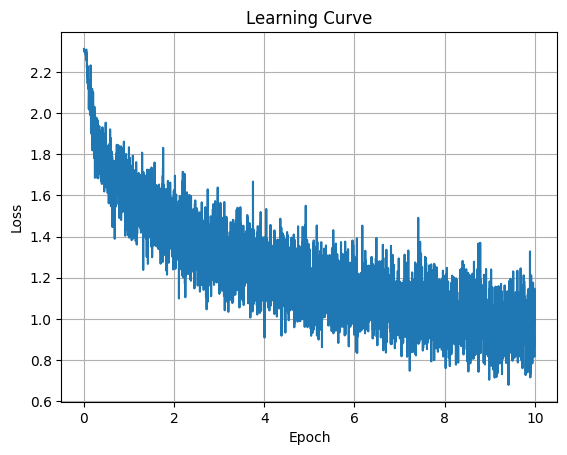

In [30]:
#PLOT THE LEARNING CURVE
iterations = np.linspace(0,epoch,num_of_batch*epoch)
plt.plot(iterations, loss_values)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

In [31]:
#TEST THE MODEL
model.eval()
correct=0
total=0

for x_val, y_val in test_generator:
  x_val = x_val.to(device)
  y_val = y_val.to(device)

  output = model(x_val)
  y_pred = output.argmax(dim=1)

  for i in range(y_pred.shape[0]):
    if y_val[i]==y_pred[i]:
      correct += 1
    total +=1

print('Validation accuracy: %.2f%%' %((100*correct)//(total)))

Validation accuracy: 62.00%


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 29, 29]             392
              ReLU-2            [-1, 8, 29, 29]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 11, 11]           2,064
              ReLU-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 256]         102,656
              ReLU-8                  [-1, 256]               0
            Linear-9                   [-1, 64]          16,448
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 122,210
Trainable params: 122,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

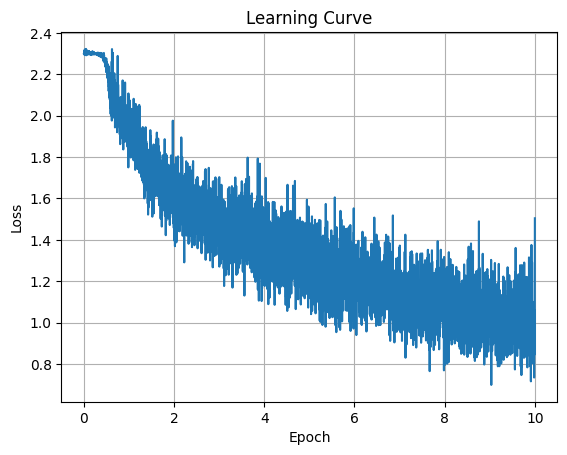

In [32]:
#Question2
#DEFINE NEURAL NETWORK MODEL
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 8, kernel_size = 4, stride = 1)
    self.conv2 = torch.nn.Conv2d(8, 16, kernel_size = 4, stride = 1)
    self.mpool = torch.nn.MaxPool2d(2)
    self.fc1 = torch.nn.Linear(400, 256)
    self.fc2 = torch.nn.Linear(256, 64)
    self.fc3 = torch.nn.Linear(64, 10)
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
    self.drop = torch.nn.Dropout(0.1)
  def forward(self, x):
    hidden = self.mpool(self.relu(self.conv1(x)))
    hidden = self.mpool(self.relu(self.conv2(hidden)))
    hidden = hidden.view(-1,400)
    hidden = self.relu(self.fc1(hidden))
    hidden = self.relu(self.fc2(hidden))
    output = self.fc3(hidden)
    return output

model = CNN()
model.to(device)
summary(model,(3,32,32))

#DEFINE LOSS FUNCTION AND OPTIMIZER
learning_rate = 0.01

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate,momentum=0.9)

#TRAIN THE MODEL
model.train()
epoch = 10

num_of_batch=int(len(train_generator.dataset)/batch_size)

loss_values = np.zeros(epoch*num_of_batch)
for i in range(epoch):
  for batch_idx, (x_train, y_train) in enumerate(train_generator):
    x_train, y_train = x_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fun(y_pred, y_train)
    loss_values[num_of_batch*i+batch_idx] = loss.item()
    loss.backward()
    optimizer.step()
    if (batch_idx+1) % batch_size == 0:
        print('Epoch: {}/{} [Batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i+1, epoch, (batch_idx+1) * len(x_train), len(train_generator.dataset),
            100. * (batch_idx+1) / len(train_generator), loss.item()))

#PLOT THE LEARNING CURVE
iterations = np.linspace(0,epoch,num_of_batch*epoch)
plt.plot(iterations, loss_values)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

#TEST THE MODEL
model.eval()
correct=0
total=0

for x_val, y_val in test_generator:
  x_val = x_val.to(device)
  y_val = y_val.to(device)

  output = model(x_val)
  y_pred = output.argmax(dim=1)

  for i in range(y_pred.shape[0]):
    if y_val[i]==y_pred[i]:
      correct += 1
    total +=1

print('Validation accuracy: %.2f%%' %((100*correct)//(total)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 29, 29]             392
           Sigmoid-2            [-1, 8, 29, 29]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 11, 11]           2,064
           Sigmoid-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 256]         102,656
           Sigmoid-8                  [-1, 256]               0
            Linear-9                   [-1, 64]          16,448
          Sigmoid-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 122,210
Trainable params: 122,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

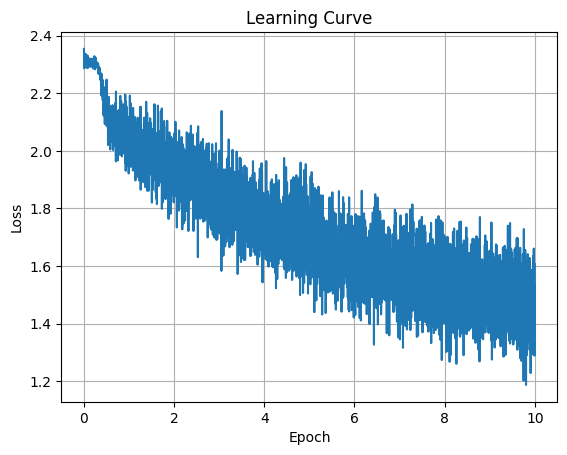

In [33]:
#Question3
#DEFINE NEURAL NETWORK MODEL
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 8, kernel_size = 4, stride = 1)
    self.conv2 = torch.nn.Conv2d(8, 16, kernel_size = 4, stride = 1)
    self.mpool = torch.nn.MaxPool2d(2)
    self.fc1 = torch.nn.Linear(400, 256)
    self.fc2 = torch.nn.Linear(256, 64)
    self.fc3 = torch.nn.Linear(64, 10)
    self.relu = torch.nn.Sigmoid()
    self.sigmoid = torch.nn.Sigmoid()
    self.drop = torch.nn.Dropout(0.1)
  def forward(self, x):
    hidden = self.mpool(self.relu(self.conv1(x)))
    hidden = self.mpool(self.relu(self.conv2(hidden)))
    hidden = hidden.view(-1,400)
    hidden = self.relu(self.fc1(hidden))
    hidden = self.relu(self.fc2(hidden))
    output = self.fc3(hidden)
    return output

model = CNN()
model.to(device)
summary(model,(3,32,32))

#DEFINE LOSS FUNCTION AND OPTIMIZER
learning_rate = 0.001

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#TRAIN THE MODEL
model.train()
epoch = 10

num_of_batch=int(len(train_generator.dataset)/batch_size)

loss_values = np.zeros(epoch*num_of_batch)
for i in range(epoch):
  for batch_idx, (x_train, y_train) in enumerate(train_generator):
    x_train, y_train = x_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fun(y_pred, y_train)
    loss_values[num_of_batch*i+batch_idx] = loss.item()
    loss.backward()
    optimizer.step()
    if (batch_idx+1) % batch_size == 0:
        print('Epoch: {}/{} [Batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i+1, epoch, (batch_idx+1) * len(x_train), len(train_generator.dataset),
            100. * (batch_idx+1) / len(train_generator), loss.item()))

#PLOT THE LEARNING CURVE
iterations = np.linspace(0,epoch,num_of_batch*epoch)
plt.plot(iterations, loss_values)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

#TEST THE MODEL
model.eval()
correct=0
total=0

for x_val, y_val in test_generator:
  x_val = x_val.to(device)
  y_val = y_val.to(device)

  output = model(x_val)
  y_pred = output.argmax(dim=1)

  for i in range(y_pred.shape[0]):
    if y_val[i]==y_pred[i]:
      correct += 1
    total +=1

print('Validation accuracy: %.2f%%' %((100*correct)//(total)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 27, 27]             872
              ReLU-2            [-1, 8, 27, 27]               0
         MaxPool2d-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 16, 8, 8]           4,624
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 256]          65,792
              ReLU-8                  [-1, 256]               0
            Linear-9                   [-1, 64]          16,448
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 88,386
Trainable params: 88,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

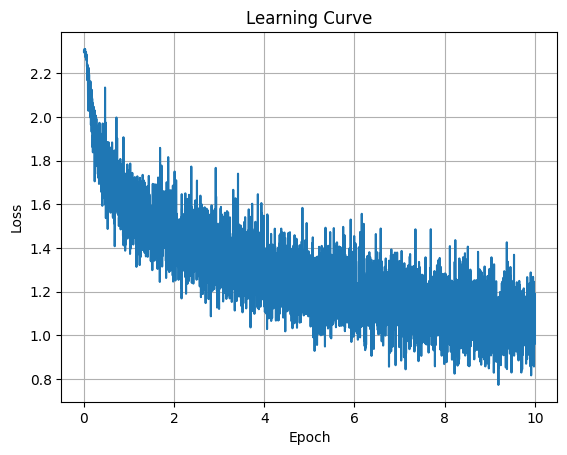

In [34]:
#Question4
#DEFINE NEURAL NETWORK MODEL
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 8, kernel_size = 6, stride = 1)
    self.conv2 = torch.nn.Conv2d(8, 16, kernel_size = 6, stride = 1)
    self.mpool = torch.nn.MaxPool2d(2)
    self.fc1 = torch.nn.Linear(256, 256)
    self.fc2 = torch.nn.Linear(256, 64)
    self.fc3 = torch.nn.Linear(64, 10)
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
    self.drop = torch.nn.Dropout(0.1)
  def forward(self, x):
    hidden = self.mpool(self.relu(self.conv1(x)))
    hidden = self.mpool(self.relu(self.conv2(hidden)))
    hidden = hidden.view(-1,256)
    hidden = self.relu(self.fc1(hidden))
    hidden = self.relu(self.fc2(hidden))
    output = self.fc3(hidden)
    return output

model = CNN()
model.to(device)
summary(model,(3,32,32))

#DEFINE LOSS FUNCTION AND OPTIMIZER
learning_rate = 0.001

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#TRAIN THE MODEL
model.train()
epoch = 10

num_of_batch=int(len(train_generator.dataset)/batch_size)

loss_values = np.zeros(epoch*num_of_batch)
for i in range(epoch):
  for batch_idx, (x_train, y_train) in enumerate(train_generator):
    x_train, y_train = x_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fun(y_pred, y_train)
    loss_values[num_of_batch*i+batch_idx] = loss.item()
    loss.backward()
    optimizer.step()
    if (batch_idx+1) % batch_size == 0:
        print('Epoch: {}/{} [Batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i+1, epoch, (batch_idx+1) * len(x_train), len(train_generator.dataset),
            100. * (batch_idx+1) / len(train_generator), loss.item()))

#PLOT THE LEARNING CURVE
iterations = np.linspace(0,epoch,num_of_batch*epoch)
plt.plot(iterations, loss_values)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

#TEST THE MODEL
model.eval()
correct=0
total=0

for x_val, y_val in test_generator:
  x_val = x_val.to(device)
  y_val = y_val.to(device)

  output = model(x_val)
  y_pred = output.argmax(dim=1)

  for i in range(y_pred.shape[0]):
    if y_val[i]==y_pred[i]:
      correct += 1
    total +=1

print('Validation accuracy: %.2f%%' %((100*correct)//(total)))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 29, 29]             392
              ReLU-2            [-1, 8, 29, 29]               0
            Conv2d-3           [-1, 16, 26, 26]           2,064
              ReLU-4           [-1, 16, 26, 26]               0
            Linear-5                  [-1, 256]       2,769,152
              ReLU-6                  [-1, 256]               0
            Linear-7                   [-1, 64]          16,448
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 10]             650
Total params: 2,788,706
Trainable params: 2,788,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 10.64
Estimated Total Size (MB): 10.92
-------------------------------------

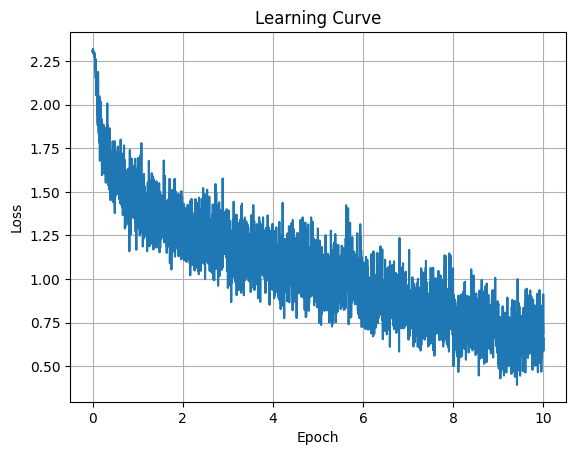

In [35]:
#Question5
#DEFINE NEURAL NETWORK MODEL
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 8, kernel_size = 4, stride = 1)
    self.conv2 = torch.nn.Conv2d(8, 16, kernel_size = 4, stride = 1)
    self.mpool = torch.nn.MaxPool2d(2)
    self.fc1 = torch.nn.Linear(10816, 256)
    self.fc2 = torch.nn.Linear(256, 64)
    self.fc3 = torch.nn.Linear(64, 10)
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
    self.drop = torch.nn.Dropout(0.1)
  def forward(self, x):
    hidden = (self.relu(self.conv1(x)))
    hidden = (self.relu(self.conv2(hidden)))
    hidden = hidden.view(-1,10816)
    hidden = self.relu(self.fc1(hidden))
    hidden = self.relu(self.fc2(hidden))
    output = self.fc3(hidden)
    return output

model = CNN()
model.to(device)
summary(model,(3,32,32))

#DEFINE LOSS FUNCTION AND OPTIMIZER
learning_rate = 0.001

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#TRAIN THE MODEL
model.train()
epoch = 10

num_of_batch=int(len(train_generator.dataset)/batch_size)

loss_values = np.zeros(epoch*num_of_batch)
for i in range(epoch):
  for batch_idx, (x_train, y_train) in enumerate(train_generator):
    x_train, y_train = x_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fun(y_pred, y_train)
    loss_values[num_of_batch*i+batch_idx] = loss.item()
    loss.backward()
    optimizer.step()
    if (batch_idx+1) % batch_size == 0:
        print('Epoch: {}/{} [Batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i+1, epoch, (batch_idx+1) * len(x_train), len(train_generator.dataset),
            100. * (batch_idx+1) / len(train_generator), loss.item()))

#PLOT THE LEARNING CURVE
iterations = np.linspace(0,epoch,num_of_batch*epoch)
plt.plot(iterations, loss_values)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

#TEST THE MODEL
model.eval()
correct=0
total=0

for x_val, y_val in test_generator:
  x_val = x_val.to(device)
  y_val = y_val.to(device)

  output = model(x_val)
  y_pred = output.argmax(dim=1)

  for i in range(y_pred.shape[0]):
    if y_val[i]==y_pred[i]:
      correct += 1
    total +=1

print('Validation accuracy: %.2f%%' %((100*correct)//(total)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 29, 29]             392
              ReLU-2            [-1, 8, 29, 29]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 11, 11]           2,064
              ReLU-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 32, 2, 2]           8,224
              ReLU-8             [-1, 32, 2, 2]               0
         MaxPool2d-9             [-1, 32, 1, 1]               0
           Linear-10                  [-1, 256]           8,448
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 64]          16,448
             ReLU-13                   [-1, 64]               0
           Linear-14                   

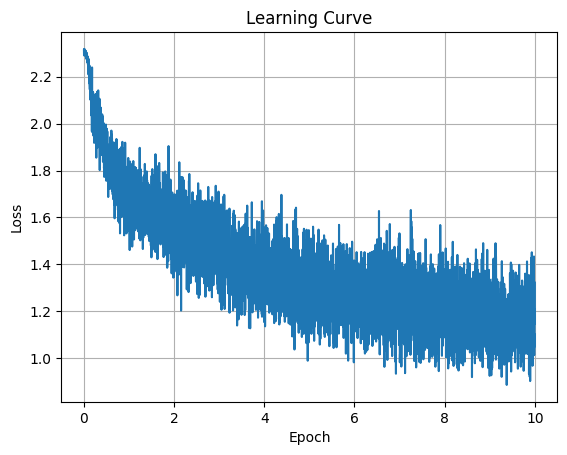

In [36]:
#Question6
#DEFINE NEURAL NETWORK MODEL
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 8, kernel_size = 4, stride = 1)
    self.conv2 = torch.nn.Conv2d(8, 16, kernel_size = 4, stride = 1)
    self.conv3 = torch.nn.Conv2d(16, 32, kernel_size = 4, stride = 1)
    self.mpool = torch.nn.MaxPool2d(2)
    self.fc1 = torch.nn.Linear(32, 256)
    self.fc2 = torch.nn.Linear(256, 64)
    self.fc3 = torch.nn.Linear(64, 10)
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
    self.drop = torch.nn.Dropout(0.1)
  def forward(self, x):
    hidden = self.mpool(self.relu(self.conv1(x)))
    hidden = self.mpool(self.relu(self.conv2(hidden)))
    hidden = self.mpool(self.relu(self.conv3(hidden)))
    hidden = hidden.view(-1,32)
    hidden = self.relu(self.fc1(hidden))
    hidden = self.relu(self.fc2(hidden))
    output = self.fc3(hidden)
    return output

model = CNN()
model.to(device)
summary(model,(3,32,32))

#DEFINE LOSS FUNCTION AND OPTIMIZER
learning_rate = 0.001

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#TRAIN THE MODEL
model.train()
epoch = 10

num_of_batch=int(len(train_generator.dataset)/batch_size)

loss_values = np.zeros(epoch*num_of_batch)
for i in range(epoch):
  for batch_idx, (x_train, y_train) in enumerate(train_generator):
    x_train, y_train = x_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fun(y_pred, y_train)
    loss_values[num_of_batch*i+batch_idx] = loss.item()
    loss.backward()
    optimizer.step()
    if (batch_idx+1) % batch_size == 0:
        print('Epoch: {}/{} [Batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i+1, epoch, (batch_idx+1) * len(x_train), len(train_generator.dataset),
            100. * (batch_idx+1) / len(train_generator), loss.item()))

#PLOT THE LEARNING CURVE
iterations = np.linspace(0,epoch,num_of_batch*epoch)
plt.plot(iterations, loss_values)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

#TEST THE MODEL
model.eval()
correct=0
total=0

for x_val, y_val in test_generator:
  x_val = x_val.to(device)
  y_val = y_val.to(device)

  output = model(x_val)
  y_pred = output.argmax(dim=1)

  for i in range(y_pred.shape[0]):
    if y_val[i]==y_pred[i]:
      correct += 1
    total +=1

print('Validation accuracy: %.2f%%' %((100*correct)//(total)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 29, 29]             392
              ReLU-2            [-1, 8, 29, 29]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 11, 11]           2,064
              ReLU-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 32, 2, 2]           8,224
              ReLU-8             [-1, 32, 2, 2]               0
         MaxPool2d-9             [-1, 32, 1, 1]               0
           Linear-10                  [-1, 256]           8,448
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 64]          16,448
             ReLU-13                   [-1, 64]               0
           Linear-14                   

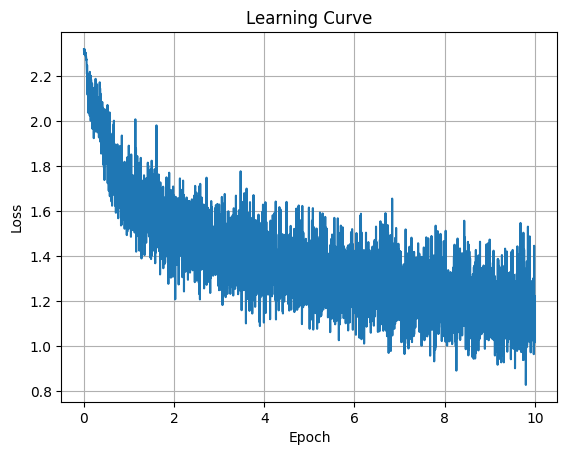

In [37]:
#Question7
#DEFINE NEURAL NETWORK MODEL
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 4, stride = 1)
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 4, stride = 1)
    self.conv3 = torch.nn.Conv2d(16, 32, kernel_size = 4, stride = 1)
    self.mpool = torch.nn.MaxPool2d(2)
    self.fc1 = torch.nn.Linear(32, 1024)
    self.fc2 = torch.nn.Linear(1024, 256)
    self.fc3 = torch.nn.Linear(256, 10)
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
    self.drop = torch.nn.Dropout(0.1)
  def forward(self, x):
    hidden = self.mpool(self.relu(self.conv1(x)))
    hidden = self.mpool(self.relu(self.conv2(hidden)))

    hidden = hidden.view(-1,32)
    hidden = self.relu(self.fc1(hidden))
    hidden = self.relu(self.fc2(hidden))
    output = self.fc3(hidden)
    return output

model = CNN()
model.to(device)
summary(model,(3,32,32))

#DEFINE LOSS FUNCTION AND OPTIMIZER
learning_rate = 0.001

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

#TRAIN THE MODEL
model.train()
epoch = 10

num_of_batch=int(len(train_generator.dataset)/batch_size)

loss_values = np.zeros(epoch*num_of_batch)
for i in range(epoch):
  for batch_idx, (x_train, y_train) in enumerate(train_generator):
    x_train, y_train = x_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fun(y_pred, y_train)
    loss_values[num_of_batch*i+batch_idx] = loss.item()
    loss.backward()
    optimizer.step()
    if (batch_idx+1) % batch_size == 0:
        print('Epoch: {}/{} [Batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i+1, epoch, (batch_idx+1) * len(x_train), len(train_generator.dataset),
            100. * (batch_idx+1) / len(train_generator), loss.item()))

#PLOT THE LEARNING CURVE
iterations = np.linspace(0,epoch,num_of_batch*epoch)
plt.plot(iterations, loss_values)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

#TEST THE MODEL
model.eval()
correct=0
total=0

for x_val, y_val in test_generator:
  x_val = x_val.to(device)
  y_val = y_val.to(device)

  output = model(x_val)
  y_pred = output.argmax(dim=1)

  for i in range(y_pred.shape[0]):
    if y_val[i]==y_pred[i]:
      correct += 1
    total +=1

print('Validation accuracy: %.2f%%' %((100*correct)//(total)))





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         MaxPool2d-5           [-1, 64, 16, 16]               0
           Dropout-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,584
      BatchNorm2d-10          [-1, 128, 16, 16]             256
        MaxPool2d-11            [-1, 128, 8, 8]               0
          Dropout-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
      BatchNorm2d-14            [-1, 25

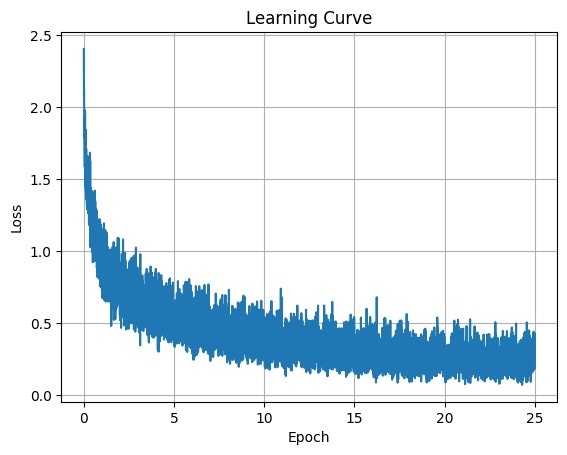

In [48]:
#Question8
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.3)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.4)

        # Convolutional Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(0.4)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolutional Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # Convolutional Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # Convolutional Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.drop3(x)

        # Fully Connected Layers
        x = x.view(-1, 256 * 4 * 4)  # Flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.drop3(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x




model = CNN()
model.to(device)
summary(model, (3, 32, 32))

#DEFINE LOSS FUNCTION AND OPTIMIZER
learning_rate = 0.001

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,weight_decay=1e-4)

#TRAIN THE MODEL
model.train()
epoch = 25

num_of_batch=int(len(train_generator.dataset)/batch_size)

loss_values = np.zeros(epoch*num_of_batch)
for i in range(epoch):
  for batch_idx, (x_train, y_train) in enumerate(train_generator):
    x_train, y_train = x_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fun(y_pred, y_train)
    loss_values[num_of_batch*i+batch_idx] = loss.item()
    loss.backward()
    optimizer.step()
    if (batch_idx+1) % batch_size == 0:
        print('Epoch: {}/{} [Batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i+1, epoch, (batch_idx+1) * len(x_train), len(train_generator.dataset),
            100. * (batch_idx+1) / len(train_generator), loss.item()))

#PLOT THE LEARNING CURVE
iterations = np.linspace(0,epoch,num_of_batch*epoch)
plt.plot(iterations, loss_values)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid('on')

#TEST THE MODEL
model.eval()
correct=0
total=0

for x_val, y_val in test_generator:
  x_val = x_val.to(device)
  y_val = y_val.to(device)

  output = model(x_val)
  y_pred = output.argmax(dim=1)

  for i in range(y_pred.shape[0]):
    if y_val[i]==y_pred[i]:
      correct += 1
    total +=1

print('Validation accuracy: %.2f%%' %((100*correct)//(total)))

In [49]:
print("done")

done
